In [1]:
from huggingface_hub import login
from esm.models.esm3 import ESM3
from esm.sdk.api import ESM3InferenceClient, ESMProtein, GenerationConfig

# Will instruct you how to get an API key from huggingface hub, make one with "Read" permission.
login()

# This will download the model weights and instantiate the model on your machine.
model: ESM3InferenceClient = ESM3.from_pretrained("esm3_sm_open_v1").to("cuda") # or "cpu"

/home/alprielse/src/esm-antibody-explore/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/alprielse/src/esm-antibody-explore/.venv/lib/python3.11/site-packages/esm/pretrained.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [4]:

protein = ESMProtein.from_pdb("./data/all-nano-structures/8zer.pdb", chain_id='A')

In [5]:
encoded = model.encode(protein)

/home/alprielse/src/esm-antibody-explore/.venv/lib/python3.11/site-packages/esm/pretrained.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/hom

In [8]:
from esm.sdk.api import SamplingConfig

result = model.forward_and_sample(encoded, SamplingConfig(return_per_residue_embeddings=True))

In [10]:
result.per_residue_embedding.shape

torch.Size([122, 1536])

In [13]:
len(protein.sequence)

120

In [16]:
result.per_residue_embedding.mean(axis=0).shape

torch.Size([1536])

In [26]:
import os

def calc_embedding_from_id(pdb_id, chain):
  file_path = f"./data/all-nano-structures/{pdb_id}.pdb"

  if not os.path.exists(file_path):
    return None

  protein = ESMProtein.from_pdb(file_path, chain_id=chain)
  encoded = model.encode(protein)
  result = model.forward_and_sample(encoded, SamplingConfig(return_per_residue_embeddings=True))

  # take the mean across all residues
  fixed_width_embedding = result.per_residue_embedding.mean(axis=0)

  return fixed_width_embedding.cpu().numpy()

calc_embedding_from_id('8zer', 'H')

array([-206.64476 ,  -91.757   ,  -65.90176 , ...,    3.818   ,
         60.797504,   28.260002], dtype=float32)

In [27]:
import pandas as pd

df = pd.read_csv('./data/sabdab_nano_with_clusters.csv')
df.head()

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,pmid,seq,CDR_H1,CDR_H2,CDR_H3,CDR_concat,key,cluster-representative,cluster-member,cluster-id
0,8zer,A,NaN,0,C,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,NaN,VQLVESGGGSVQAGGSLRLSCVASGYTYCSYDMSWYRQAPGKEREF...,GYTYCSY,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_A,8zer_A,8zer_A,0
1,8zer,D,NaN,0,I,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,NaN,VQLVESGGGSVQAGGSLRLSCVASGYTYCSYDMSWYRQAPGKEREF...,GYTYCSY,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_D,8zer_A,8zer_D,0
2,8zer,F,NaN,0,B | E,protein | protein,NA | NA,spike protein s1 | spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,NaN,VQLVESGGGSVQAGGSLRLSCVASGYTYCSYDMSWYRQAPGKEREF...,GYTYCSY,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_F,8zer_A,8zer_F,0
3,8zer,H,NaN,0,G,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,NaN,EVQLVESGGGSVQAGGSLRLSCVASGYTYCSYDMSWYRQAPGKERE...,GYTYCSY,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_H,8zer_A,8zer_H,0
4,8zer,J,NaN,0,I,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,NaN,VQLVESGGGSVQAGGSLRLSCVASGYTYCSYDMSWYRQAPGKEREF...,GYTYCSY,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_J,8zer_A,8zer_J,0


In [28]:
import swifter

def map_row_to_embedding(row):
  return calc_embedding_from_id(row['pdb'], row['Hchain'])

target = df[df['pdb'].notna() & df['Hchain'].notna()]
print(len(target))
df['embedding'] = target.swifter.apply(map_row_to_embedding, axis=1)

3309


Pandas Apply:   0%|          | 0/3309 [00:00<?, ?it/s]

In [29]:
df.head()

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,seq,CDR_H1,CDR_H2,CDR_H3,CDR_concat,key,cluster-representative,cluster-member,cluster-id,embedding
0,8zer,A,NaN,0,C,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,VQLVESGGGSVQAGGSLRLSCVASGYTYCSYDMSWYRQAPGKEREF...,GYTYCSY,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_A,8zer_A,8zer_A,0,"[-205.96515, -105.54405, -62.249485, 37.06301,..."
1,8zer,D,NaN,0,I,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,VQLVESGGGSVQAGGSLRLSCVASGYTYCSYDMSWYRQAPGKEREF...,GYTYCSY,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_D,8zer_A,8zer_D,0,"[-207.91801, -103.120895, -61.928276, 38.03176..."
2,8zer,F,NaN,0,B | E,protein | protein,NA | NA,spike protein s1 | spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,VQLVESGGGSVQAGGSLRLSCVASGYTYCSYDMSWYRQAPGKEREF...,GYTYCSY,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_F,8zer_A,8zer_F,0,"[-209.48795, -104.803276, -70.25512, 40.18084,..."
3,8zer,H,NaN,0,G,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,EVQLVESGGGSVQAGGSLRLSCVASGYTYCSYDMSWYRQAPGKERE...,GYTYCSY,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_H,8zer_A,8zer_H,0,"[-206.64476, -91.757, -65.90176, 38.4015, -85...."
4,8zer,J,NaN,0,I,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,VQLVESGGGSVQAGGSLRLSCVASGYTYCSYDMSWYRQAPGKEREF...,GYTYCSY,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_J,8zer_A,8zer_J,0,"[-207.31248, -100.43685, -69.55968, 37.554047,..."


In [31]:
df.to_csv('./data/sabdab_nano_with_embeddings.csv')

In [49]:
import numpy as np
embeddings = np.vstack(df[df['embedding'].notna()]['embedding'].values)

In [52]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

mask = df['embedding'].notna()

# Assign t-SNE results to the corresponding rows in the DataFrame
df.loc[mask, 'tsne_x'] = tsne_results[:, 0]
df.loc[mask, 'tsne_y'] = tsne_results[:, 1]

In [53]:
df.head()

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,CDR_H2,CDR_H3,CDR_concat,key,cluster-representative,cluster-member,cluster-id,embedding,tsne_x,tsne_y
0,8zer,A,NaN,0,C,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_A,8zer_A,8zer_A,0,"[-205.96515, -105.54405, -62.249485, 37.06301,...",-7.398866,-8.880091
1,8zer,D,NaN,0,I,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_D,8zer_A,8zer_D,0,"[-207.91801, -103.120895, -61.928276, 38.03176...",-7.360772,-8.735465
2,8zer,F,NaN,0,B | E,protein | protein,NA | NA,spike protein s1 | spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_F,8zer_A,8zer_F,0,"[-209.48795, -104.803276, -70.25512, 40.18084,...",-7.404265,-8.796730
3,8zer,H,NaN,0,G,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_H,8zer_A,8zer_H,0,"[-206.64476, -91.757, -65.90176, 38.4015, -85....",-7.336391,-8.933246
4,8zer,J,NaN,0,I,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/04/24,...,RRDGS,WACSSGGD,GYTYCSYRRDGSWACSSGGD,8zer_J,8zer_A,8zer_J,0,"[-207.31248, -100.43685, -69.55968, 37.554047,...",-7.458703,-8.782226


In [85]:
# color pallete taken from here https://www.heavy.ai/blog/12-color-palettes-for-telling-better-stories-with-your-data
color_array = ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6"]


unique_groups = df['cluster-id'].unique()
color_map = {group: color_array[i % len(color_array)] for i, group in enumerate(unique_groups)}

df['color'] = df['cluster-id'].map(color_map)

In [86]:
df['color']

0       #ea5545
1       #ea5545
2       #ea5545
3       #ea5545
4       #ea5545
         ...   
3316    #edbf33
3317    #ef9b20
3318    #27aeef
3319    #87bc45
3320    #ef9b20
Name: color, Length: 3321, dtype: object

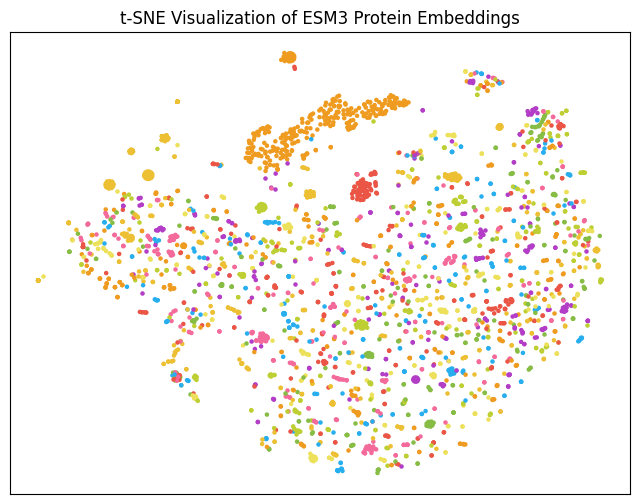

In [87]:
plt.figure(figsize=(8, 6))

# Optional: color by label if available
for cluster_id in df['cluster-id'].unique():
  subset = df[df['cluster-id'] == cluster_id]
  plt.scatter(subset['tsne_x'], subset['tsne_y'], c=subset['color'], s=5,)

plt.title('t-SNE Visualization of ESM3 Protein Embeddings')
plt.xticks([]) 
plt.yticks([]) 
plt.show()

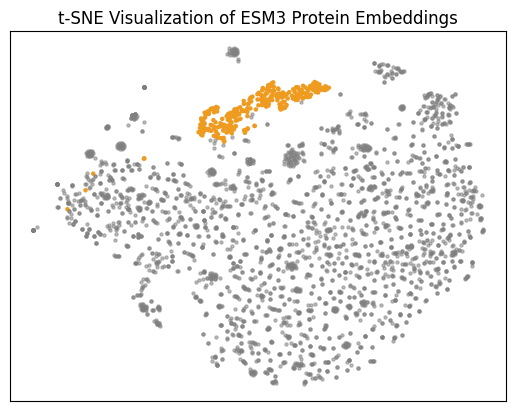

In [91]:
target_cluster_id = 11
for cluster_id in df['cluster-id'].unique():
  subset = df[df['cluster-id'] == cluster_id]
  plt.scatter(subset['tsne_x'], subset['tsne_y'], c=subset['color'] if cluster_id   == target_cluster_id else 'gray', 
              s=5, alpha=1 if cluster_id == target_cluster_id else .5)

plt.title('t-SNE Visualization of ESM3 Protein Embeddings')
plt.xticks([]) 
plt.yticks([]) 
plt.show()

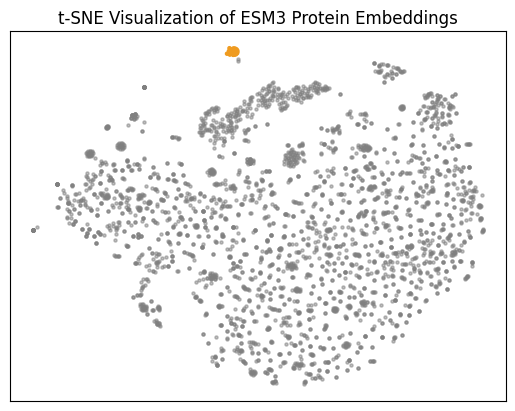

In [92]:
target_cluster_id = 46
for cluster_id in df['cluster-id'].unique():
  subset = df[df['cluster-id'] == cluster_id]
  plt.scatter(subset['tsne_x'], subset['tsne_y'], c=subset['color'] if cluster_id   == target_cluster_id else 'gray', 
              s=5, alpha=1 if cluster_id == target_cluster_id else .5)

plt.title('t-SNE Visualization of ESM3 Protein Embeddings')
plt.xticks([]) 
plt.yticks([]) 
plt.show()

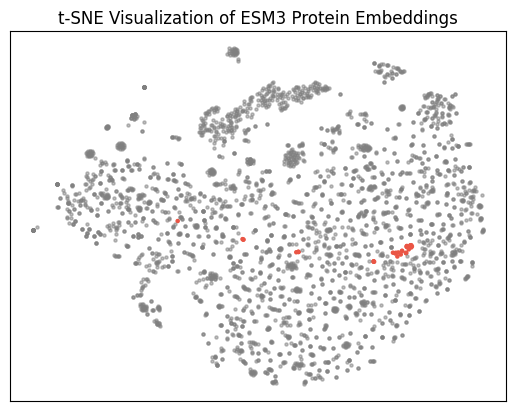

In [94]:
target_cluster_id = 287
for cluster_id in df['cluster-id'].unique():
  subset = df[df['cluster-id'] == cluster_id]
  plt.scatter(subset['tsne_x'], subset['tsne_y'], c=subset['color'] if cluster_id   == target_cluster_id else 'gray', 
              s=5, alpha=1 if cluster_id == target_cluster_id else .5)

plt.title('t-SNE Visualization of ESM3 Protein Embeddings')
plt.xticks([]) 
plt.yticks([]) 
plt.show()

In [96]:
df[df['cluster-id'] == 11].head(50)

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,CDR_H3,CDR_concat,key,cluster-representative,cluster-member,cluster-id,embedding,tsne_x,tsne_y,color
33,8xve,N,NaN,0,A | B,protein | protein,NA | NA,isoform gnas-2 of guanine nucleotide-binding p...,SIGNALING PROTEIN,08/28/24,...,CPAPFTAY,GFTFSNYSSGASCPAPFTAY,8xve_N,8xve_N,8xve_N,11,"[-209.47339, -107.836426, -53.097656, 67.51538...",2.482706,48.644234,#ef9b20
34,8xvh,N,NaN,0,A | B,protein | protein,NA | NA,isoform gnas-2 of guanine nucleotide-binding p...,SIGNALING PROTEIN,08/28/24,...,CPAPFTAY,GFTFSNYSSGASCPAPFTAY,8xvh_N,8xve_N,8xvh_N,11,"[-182.89209, -67.96631, -27.72168, 31.026367, ...",-29.815948,38.708687,#ef9b20
35,8xvi,N,NaN,0,A | B,protein | protein,NA | NA,isoform gnas-2 of guanine nucleotide-binding p...,SIGNALING PROTEIN,08/28/24,...,CPAPFTAY,GFTFSNYSSGASCPAPFTAY,8xvi_N,8xve_N,8xvi_N,11,"[-177.25635, -73.80176, -18.135742, 36.6167, -...",-31.088835,37.643501,#ef9b20
45,8yw5,N,NaN,0,A | B,protein | protein,NA | NA,guanine nucleotide-binding protein g(s) subuni...,STRUCTURAL PROTEIN,08/07/24,...,CPAPFTAY,GFTFSNYSSGASCPAPFTAY,8yw5_N,8xve_N,8yw5_N,11,"[-209.54327, -99.35865, -58.33149, 62.172356, ...",3.780043,46.403019,#ef9b20
57,8zsj,N,NaN,0,A | B,protein | protein,NA | NA,guanine nucleotide-binding protein g(s) subuni...,MEMBRANE PROTEIN/IMMUNE SYSTEM,07/24/24,...,CPAPFTAY,GFTFSNYSSGASCPAPFTAY,8zsj_N,8xve_N,8zsj_N,11,"[-218.4404, -105.478195, -60.51744, 67.20155, ...",8.102557,50.932941,#ef9b20
58,8zsp,N,NaN,0,A | B,protein | protein,NA | NA,guanine nucleotide-binding protein g(s) subuni...,MEMBRANE PROTEIN/IMMUNE SYSTEM,07/24/24,...,CPAPFTAY,GFTFSNYSSGASCPAPFTAY,8zsp_N,8xve_N,8zsp_N,11,"[-209.01018, -105.4375, -63.513565, 67.15843, ...",-6.627544,49.089691,#ef9b20
59,8zss,N,NaN,0,A | B,protein | protein,NA | NA,guanine nucleotide-binding protein g(s) subuni...,MEMBRANE PROTEIN/IMMUNE SYSTEM,01/08/09,...,CPAPFTAY,GFTFSNYSSGASCPAPFTAY,8zss_N,8xve_N,8zss_N,11,"[-195.80426, -88.72044, -58.7093, 46.531006, -...",-13.742929,45.569756,#ef9b20
60,8zsv,N,NaN,0,A | B,protein | protein,NA | NA,guanine nucleotide-binding protein g(s) subuni...,MEMBRANE PROTEIN/IMMUNE SYSTEM,01/08/09,...,CPAPFTAY,GFTFSNYSSGASCPAPFTAY,8zsv_N,8xve_N,8zsv_N,11,"[-209.13081, -101.80135, -59.53052, 57.72287, ...",-6.605840,49.117615,#ef9b20
117,8xql,N,NaN,0,A | B,protein | protein,NA | NA,guanine nucleotide-binding protein g(t) subuni...,SIGNALING PROTEIN,07/10/24,...,CPAPFTAY,GFTFSNYSSGASCPAPFTAY,8xql_N,8xve_N,8xql_N,11,"[-210.2469, -97.42891, -58.81632, 68.33445, -4...",-4.952469,49.100613,#ef9b20
118,8xqr,N,NaN,0,A | B,protein | protein,NA | NA,guanine nucleotide-binding protein g(t) subuni...,SIGNALING PROTEIN,07/10/24,...,CPAPFTAY,GFTFSNYSSGASCPAPFTAY,8xqr_N,8xve_N,8xqr_N,11,"[-204.82324, -94.09542, -63.140743, 53.24189, ...",-5.329157,49.177067,#ef9b20
